In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import natsort
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define constants
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3


In [3]:
di1 = "./graduation_dataset/final_data/5. mask_glasses/train/"

filenames = os.listdir(di1)

categories = []

for filename in filenames:
    category = filename.split('_')[0]
    if category == 'noglasses':
        categories.append(0)
    else:
        categories.append(1)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,glasses_ (404).jpg,1
1,glasses_ (414).jpg,1
2,glasses_ (492).jpg,1
3,glasses_ (659).jpg,1
4,glasses_0 (1).png,1


In [4]:
df.tail()

,filename,category
2067,noglasses_299.jpg,0
2068,noglasses_300.jpg,0
2069,noglasses_301.jpg,0
2070,noglasses_302.jpg,0
2071,noglasses_303.jpg,0


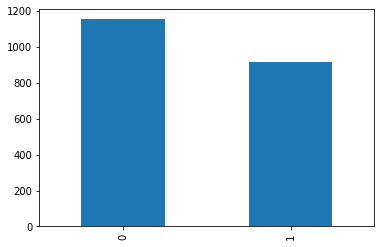

In [5]:
df['category'].value_counts().plot.bar()

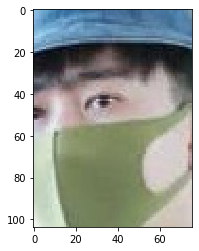

In [6]:
# See sample image
sample = random.choice(filenames)
image = load_img(di1+sample)
plt.imshow(image)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

In [8]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
# Early Stop
earlystop = EarlyStopping(patience=10)

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [11]:
callbacks= [earlystop, learning_rate_reduction]

In [12]:
df["category"] = df["category"].replace({0: 'unglasses', 1: 'glasses'})

In [13]:
df.tail()

,filename,category
2067,noglasses_299.jpg,unglasses
2068,noglasses_300.jpg,unglasses
2069,noglasses_301.jpg,unglasses
2070,noglasses_302.jpg,unglasses
2071,noglasses_303.jpg,unglasses


In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

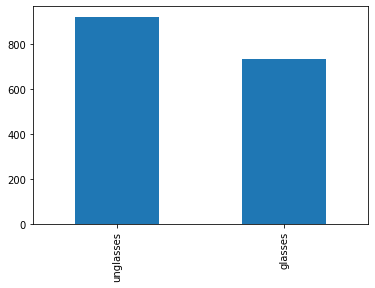

In [15]:
train_df['category'].value_counts().plot.bar()

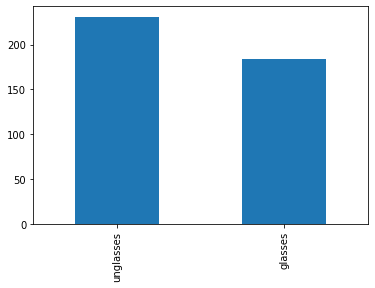

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
#Train Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
     train_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)




Found 1657 validated image filenames belonging to 2 classes.


In [19]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)


Found 415 validated image filenames belonging to 2 classes.


In [20]:
#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


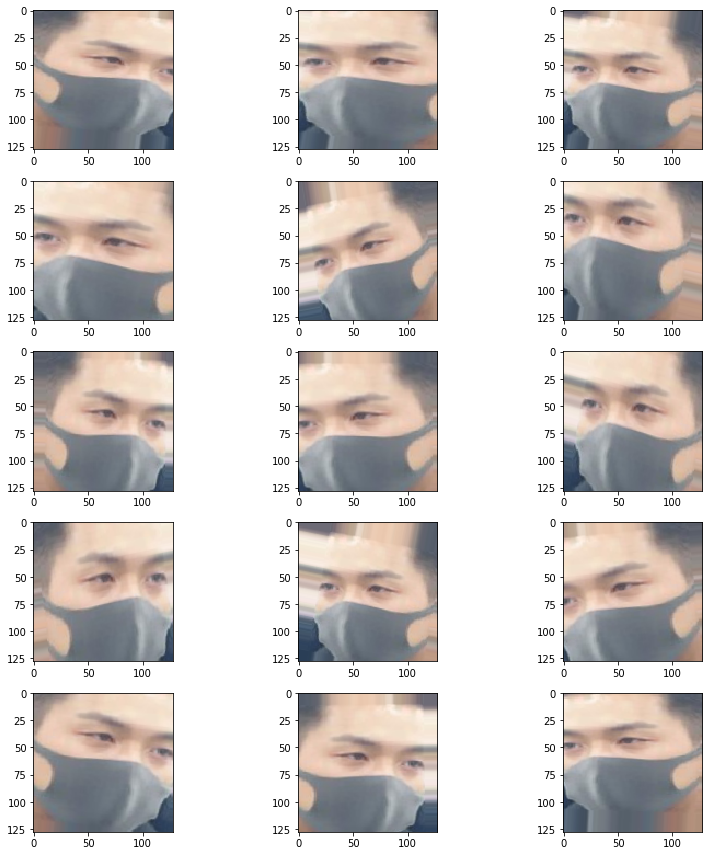

In [21]:
plt.figure(figsize=(12,12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [22]:
# Fit model
epochs = 3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data= validation_generator,
    validation_steps= total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    #callbacks=callbacks
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
110/110 [==============================] - 82s 748ms/step - loss: 0.7586 - accuracy: 0.5359 - val_loss: 0.6818 - val_accuracy: 0.5654
Epoch 2/50
110/110 [==============================] - 74s 672ms/step - loss: 0.6678 - accuracy: 0.5981 - val_loss: 0.6626 - val_accuracy: 0.6370
Epoch 3/50
110/110 [==============================] - 55s 498ms/step - loss: 0.6457 - accuracy: 0.6255 - val_loss: 0.6505 - val_accuracy: 0.6716
Epoch 4/50
110/110 [==============================] - 50s 452ms/step - loss: 0.6226 - accuracy: 0.6565 - val_loss: 0.6236 - val_accuracy: 0.7160
Epoch 5/50
110/110 [==============================] - 52s 468ms/step - loss: 0.5757 - accuracy: 0.6961 - val_loss: 0.5935 - val_accuracy: 0.7407
Epoch 6/50
110/110 [==============================] - 67s 607ms/step - loss: 0.5364 - accuracy: 0.7412 - val_loss: 0.5607 - val_accuracy: 0.7481
Epoch 7/50
110/110 [==============================] - 

In [23]:
model.save_weights("mask_glasses_model_fianl3.h5")

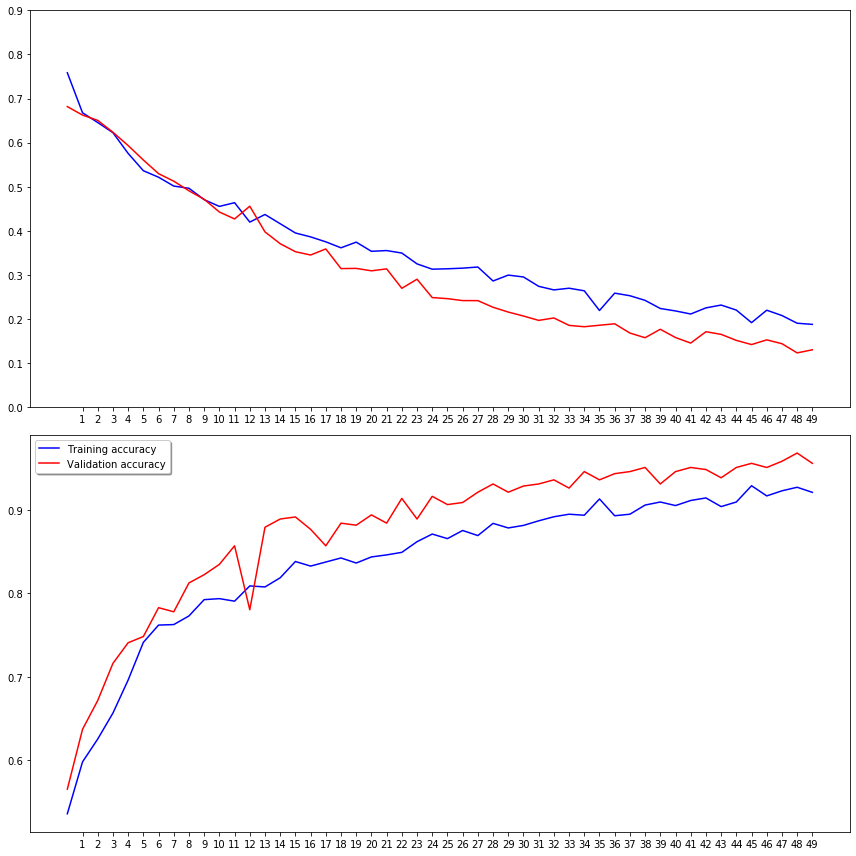

In [24]:
# Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [26]:
from PIL import Image
import numpy as np
from skimage import transform
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
import cv2

def trans_image_model(image):
    # cv2는 이미지를 읽어올때 GBR로 읽어온다. 이를 RGB로 변환
    image_for_model = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_for_model = np.array(image_for_model).astype('float32')/255

    # 안경, 선글라스, 마스크 모델용 이미지
    # RGB 3채널 + 학습사진크기 : 128 * 128
    RGBimage = transform.resize(image_for_model, (128, 128, 3))
    RGBimage = np.expand_dims(RGBimage, axis=0)

    # 감정 모델용 이미지 
    # gray 스케일로 인한 1채널 + 학습사진크기 : 48 * 48 
    GRAYimage = transform.resize(image_for_model, (48, 48, 1))
    GRAYimage = np.expand_dims(GRAYimage, axis=0)
   
    return (RGBimage, GRAYimage)


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

def face_align(image):
    predictor_model = "./grauation/landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_model)
    fa = FaceAligner(predictor, desiredFaceWidth=256)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)

    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(image[y:y + h, x:x+w], width=256)
        faceAligned = fa.align(image, gray, rect)
        return faceAligned
    
file_path = '../face/'
file_path = './graduation_dataset/glasses/test_noglasses/'
filenames = os.listdir(file_path)



for filename in filenames:
    filepath = ''
    filepath = file_path + filename
    image = cv2.imread(filepath)
    #RGBimage, GRAYimage = trans_image_model(image)
    facealigned = face_align(image)
    RGBimage, GRAYimage = trans_image_model(facealigned)
    
    result = model.predict(RGBimage)

    print(filename)
    print('예측: ')

    if result[0][0] < result[0][1]:
        print('해당 사진은 안경을 쓰지않았습니다.')
    else:
        print('해당 사진은 안경을 썼습니다.')
    
    print(result)
    print('#############################')


nomask_7983.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.08710951 0.91986746]]
#############################
nomask_7987.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.0896522 0.9096791]]
#############################
nomask_7990.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.0624355  0.93584585]]
#############################
nomask_7991.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.22151247 0.77396995]]
#############################
nomask_7992.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.13640922 0.86920846]]
#############################
nomask_7994.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.17800458 0.81245095]]
#############################
nomask_7997.jpg
예측: 
해당 사진은 안경을 썼습니다.
[[0.6676154  0.33793217]]
#############################
nomask_8001.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.28310874 0.7318823 ]]
#############################
nomask_8022.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.12040221 0.88490933]]
#############################
nomask_8025.jpg
예측: 
해당 사진은 안경을 쓰지않았습니다.
[[0.20850508 0.7906502 ]]
#############################
nomask_8026.jpg
예측: 
해당 사진은 안경을 썼습니